# Introduction
* 이번시간에서는 가장 data의 학습에서 중요하고 기반이 되어지는 Exploratory Data Analysis(EDA)에 대해서 알아보도록 하겠습니다
* Medical image에서 가장 중요한건 image에 대한 특성을 파악하고 feature를 추출하는 기반을 찾는게 중요한데요
* 이번 시간에서는 pathology의 data와 label에 대해서 알아보면서 이를 기반으로 Patch까지 적용하여 미리 학습에 적합한 데이터를 만드는 과정까지 진행해보도록 하겠습니다.

![Screenshot from 2024-02-02 15-03-59.png](<attachment:Screenshot from 2024-02-02 15-03-59.png>)
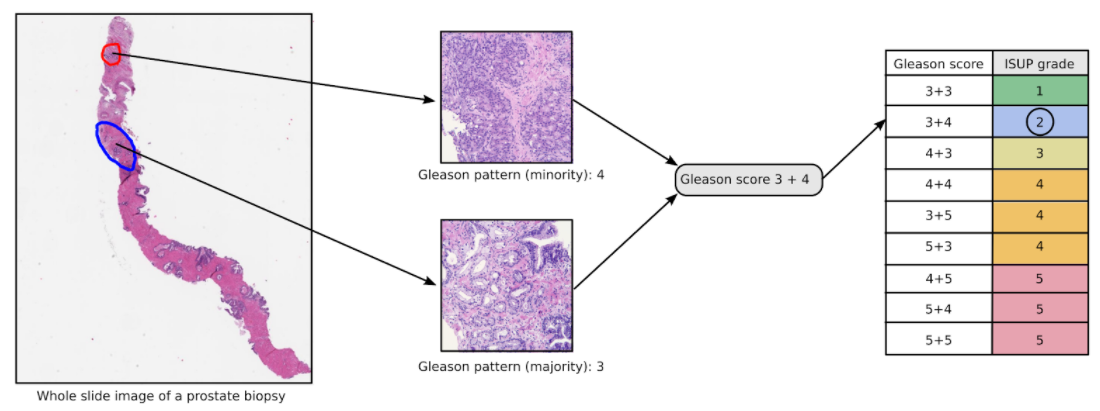

### Prostate Cancer? 
전립선에 발생하는 암.  
남성에게 가장 흔한 암중에 하나로써 천천히 자라나지만, 급격하게 빠르게 퍼질수도 있다.  
암에 대해서 score를 측정하는 것이 중요함으로 이를 gleason score라고 부른다.

### GLEASON Score? 
생검(biopsy)을 통해서 암의 Grade의 정도를 판독하는 지표   
Grade가 높을수록 전이가 큰 것을 의미함.  
Gleason score은 두 점수를 합하여 2~10까지의 점수로 판독함  


### GLEASON score to ISUP grade
International Society of Urological Pathology (ISUP) 가이드라인을 통해서 최종 Grade를 정의함.


* Gleason score 6 = ISUP grade 1
* Gleason score 7 (3 + 4) = ISUP grade 2
* Gleason score 7 (4 + 3) = ISUP grade 3
* Gleason score 8 = ISUP grade 4
* Gleason score 9-10 = ISUP grade 5

### How to get GLEASON score ? 
1. 생검을 하고 난후 조직에 haematoxylin & eosin (H&E)로 염색을 함.
2. WSI에서 흰색 구멍이 또는 속이 빈 구조의 경우 GLEASON score로 판독함. 

# 1. Load image
* 이미지를 읽기 위해서 일단 `openslide`를 통한 분석을 진행해도록 한다.

In [1]:
!pip install openslide-python

In [27]:
## Path관련 library
from pathlib import Path

## WSI관련 library
import openslide 
import cv2

## etc
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

import os

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [8]:
class cfg: 
    # Location of the training images
    BASE_PATH = '/home/minyoungxi/MINYOUNGXI/Medical/Medical Video Tutorial'
    # image and mask directories
    data_dir = f'{BASE_PATH}/train_images'
    mask_dir = f'{BASE_PATH}/train_label_masks'
    train_zip_path = 'train.zip'
    mask_zip_path = 'masks.zip'
    sz = 256
    N = 16

In [9]:
# Location of training labels
train = pd.read_csv(f'{cfg.BASE_PATH}/train.csv')
train.head()

image_id data_provider  isup_grade gleason_score
0  0005f7aaab2800f6170c399693a96917    karolinska           0           0+0
1  000920ad0b612851f8e01bcc880d9b3d    karolinska           0           0+0
2  0018ae58b01bdadc8e347995b69f99aa       radboud           4           4+4
3  001c62abd11fa4b57bf7a6c603a11bb9    karolinska           4           4+4
4  001d865e65ef5d2579c190a0e0350d8f    karolinska           0           0+0

In [10]:
train['img_path'] = train['image_id'].apply(lambda x : Path(cfg.data_dir)/ (x+'.tiff'))
train['mask_path'] = train['image_id'].apply(lambda x : Path(cfg.mask_dir)/ (x+'_mask.tiff'))
train.head()

image_id data_provider  isup_grade gleason_score  \
0  0005f7aaab2800f6170c399693a96917    karolinska           0           0+0   
1  000920ad0b612851f8e01bcc880d9b3d    karolinska           0           0+0   
2  0018ae58b01bdadc8e347995b69f99aa       radboud           4           4+4   
3  001c62abd11fa4b57bf7a6c603a11bb9    karolinska           4           4+4   
4  001d865e65ef5d2579c190a0e0350d8f    karolinska           0           0+0   

                                            img_path  \
0  /home/minyoungxi/MINYOUNGXI/Medical/Medical Vi...   
1  /home/minyoungxi/MINYOUNGXI/Medical/Medical Vi...   
2  /home/minyoungxi/MINYOUNGXI/Medical/Medical Vi...   
3  /home/minyoungxi/MINYOUNGXI/Medical/Medical Vi...   
4  /home/minyoungxi/MINYOUNGXI/Medical/Medical Vi...   

                                           mask_path  
0  /home/minyoungxi/MINYOUNGXI/Medical/Medical Vi...  
1  /home/minyoungxi/MINYOUNGXI/Medical/Medical Vi...  
2  /home/minyoungxi/MINYOUNGXI/Medical/Medical Vi...  
3  /home/minyoungxi/MINYOUNGXI/Medical/Medical Vi...  
4  /home/minyoungxi/MINYOUNGXI/Medical/Medical Vi...

In [12]:
# check NAN value
train.isna().sum()

image_id         0
data_provider    0
isup_grade       0
gleason_score    0
img_path         0
mask_path        0
dtype: int64

# 2.EDA 
* 기본적인 data의 distribution의 정보를 파악하는 것이 몹시 중요!   
* 데이터의 따른 학습방법을 설정하고 시험을 진행할수 있음  
* dataframe에 대해서 본격적인 분석을 진행을 해보자.

In [13]:
import seaborn as sns

In [14]:
palette = sns.color_palette("Set2")

sns.set_palette("Set2")

<Axes: xlabel='data_provider', ylabel='count'>

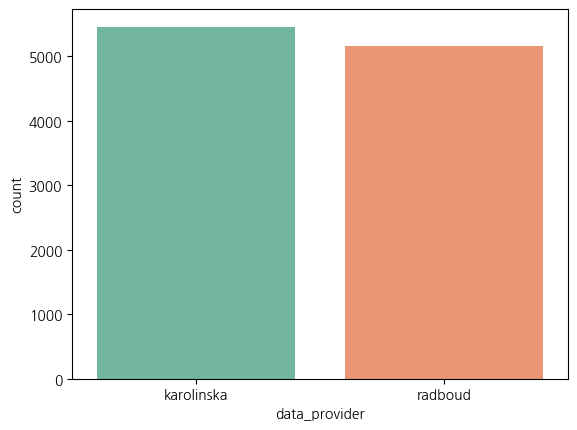

In [15]:
sns.countplot(x="data_provider", data=train, palette=palette)

gleason score는 숫자가 클수록 중증도가 높다. 



Text(0.5, 1.0, 'gleason_score by data provider')

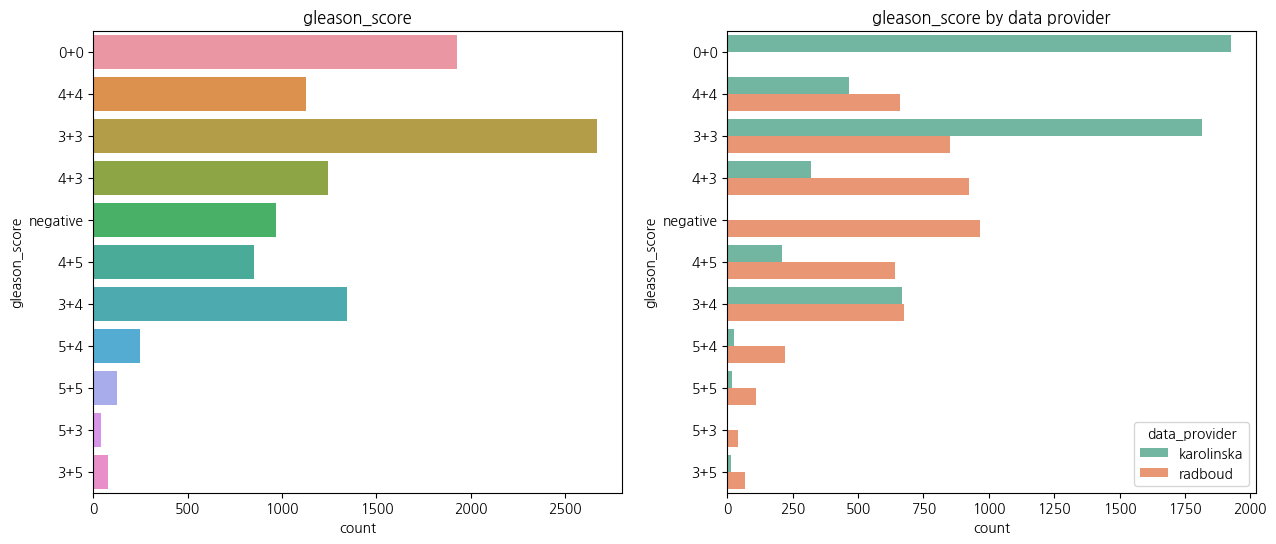

In [16]:
# 계속하여 gt의 label은 균등하게 분포가 되어있는지 보자.

fig, axs= plt.subplots(1,2,figsize=(15,6))
sns.countplot(y="gleason_score", data=train, ax=axs[0])
axs[0].set_title('gleason_score')
sns.countplot(y="gleason_score", hue="data_provider", data=train, ax=axs[1])
axs[1].set_title('gleason_score by data provider')


Text(0.5, 1.0, 'isup grade by data provider')

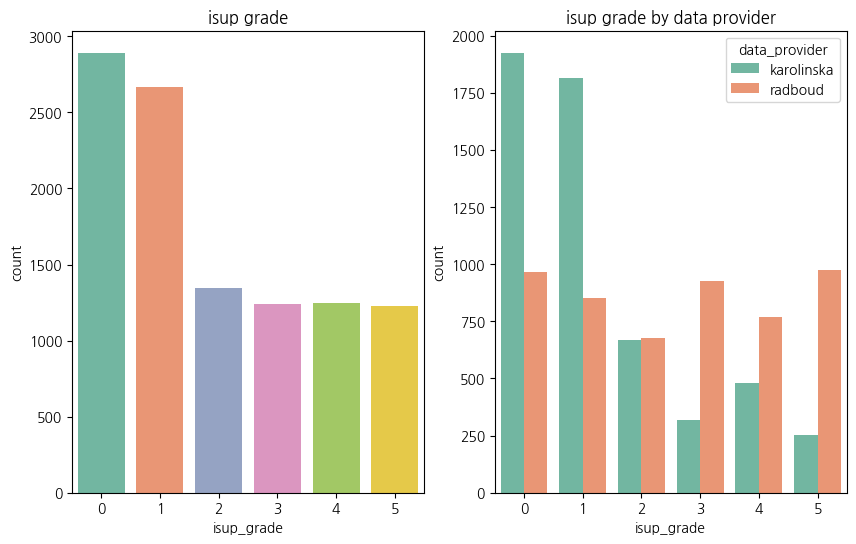

In [17]:
fig, axs= plt.subplots(1,2,figsize=(10,6))
sns.countplot(x="isup_grade", data=train, ax=axs[0])
axs[0].set_title('isup grade')
sns.countplot(x="isup_grade", hue="data_provider", data=train, ax=axs[1])
axs[1].set_title('isup grade by data provider')


In [19]:
## group마다 distribution을 살펴보자
data = [["Gleason Score", "ISUP Grade"],
        ["0+0", "0"], ["negative", "0"],
        ["3+3", "1"], ["3+4", "2"], ["4+3", "3"], 
        ["4+4", "4"], ["3+5", "4"], ["5+3", "4"],
        ["4+5", "5"], ["5+4", "5"], ["5+5", "5"],
        ]## show sample images

tmp = train.groupby('data_provider')['gleason_score'].value_counts() 
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index() 

df

data_provider gleason_score  Exams
0     karolinska           0+0   1925
1     karolinska           3+3   1814
2     karolinska           3+4    667
3     karolinska           4+4    466
4     karolinska           4+3    318
5     karolinska           4+5    208
6     karolinska           5+4     27
7     karolinska           5+5     16
8     karolinska           3+5     13
9     karolinska           5+3      2
10       radboud      negative    967
11       radboud           4+3    925
12       radboud           3+3    852
13       radboud           3+4    675
14       radboud           4+4    660
15       radboud           4+5    641
16       radboud           5+4    221
17       radboud           5+5    111
18       radboud           3+5     67
19       radboud           5+3     41

<Axes: xlabel='count', ylabel='gleason_score'>

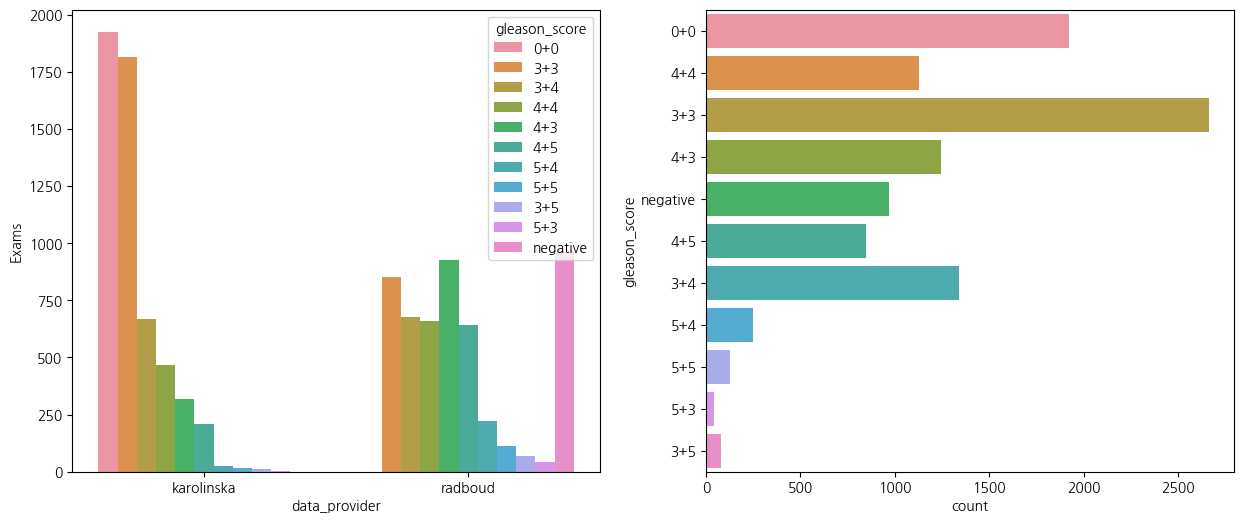

In [20]:
fig, axs= plt.subplots(1,2,figsize=(15,6))
sns.barplot(x = 'data_provider', y='Exams',hue='gleason_score',data=df, ax=axs[0]) 
sns.countplot(y="gleason_score", data=train, ax=axs[1])

#### result
위와 같이 살펴본결과 `karolinska`의 경우는 `negative, low score`일때 데이터가 많았으며   
`radboud`의 경우에서는 `high score`이 데이터가 일반적으로 많았다.  
또한 최종적으로 전체 데이터에서는 `3+3`의 데이터가 많았고 `3+5`의 데이터는 작았는데 이를 통해서 fold의 나눔에 도움을 줄것이다.

# 3. Load image and Anylsis
* 데이터를 분포를 파악했으니 이제 smaple이미지를 읽어보고 이를 어떻게 처리할지에 대해서 살펴보자.
1. data provider 마다 sample image를 읽어보기
2. Gleason score마다 data읽어보기
3. mask annoation과 함께 읽어보기 
4. mask와 함께 데이터 tiling을 해보기

In [35]:
def multi_plot(df, region=(0,0), level=-1, crop_size=(256,256)): 
    f, ax = plt.subplots(3,3, figsize=(15,15))
    for i, row in enumerate(df.itertuples()):
        image = openslide.OpenSlide(row.img_path)
        slevel = image.level_count -1 if level == -1 else level
        patch = image.read_region(region, slevel, crop_size)
        ax[i//3, i%3].imshow(patch) 
        image.close()       
        ax[i//3, i%3].axis('off')
        
        image_id = row.image_id
        data_provider = row.data_provider
        isup_grade = row.isup_grade
        gleason_score = row.gleason_score
        ax[i//3, i%3].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score}")

    plt.show() 

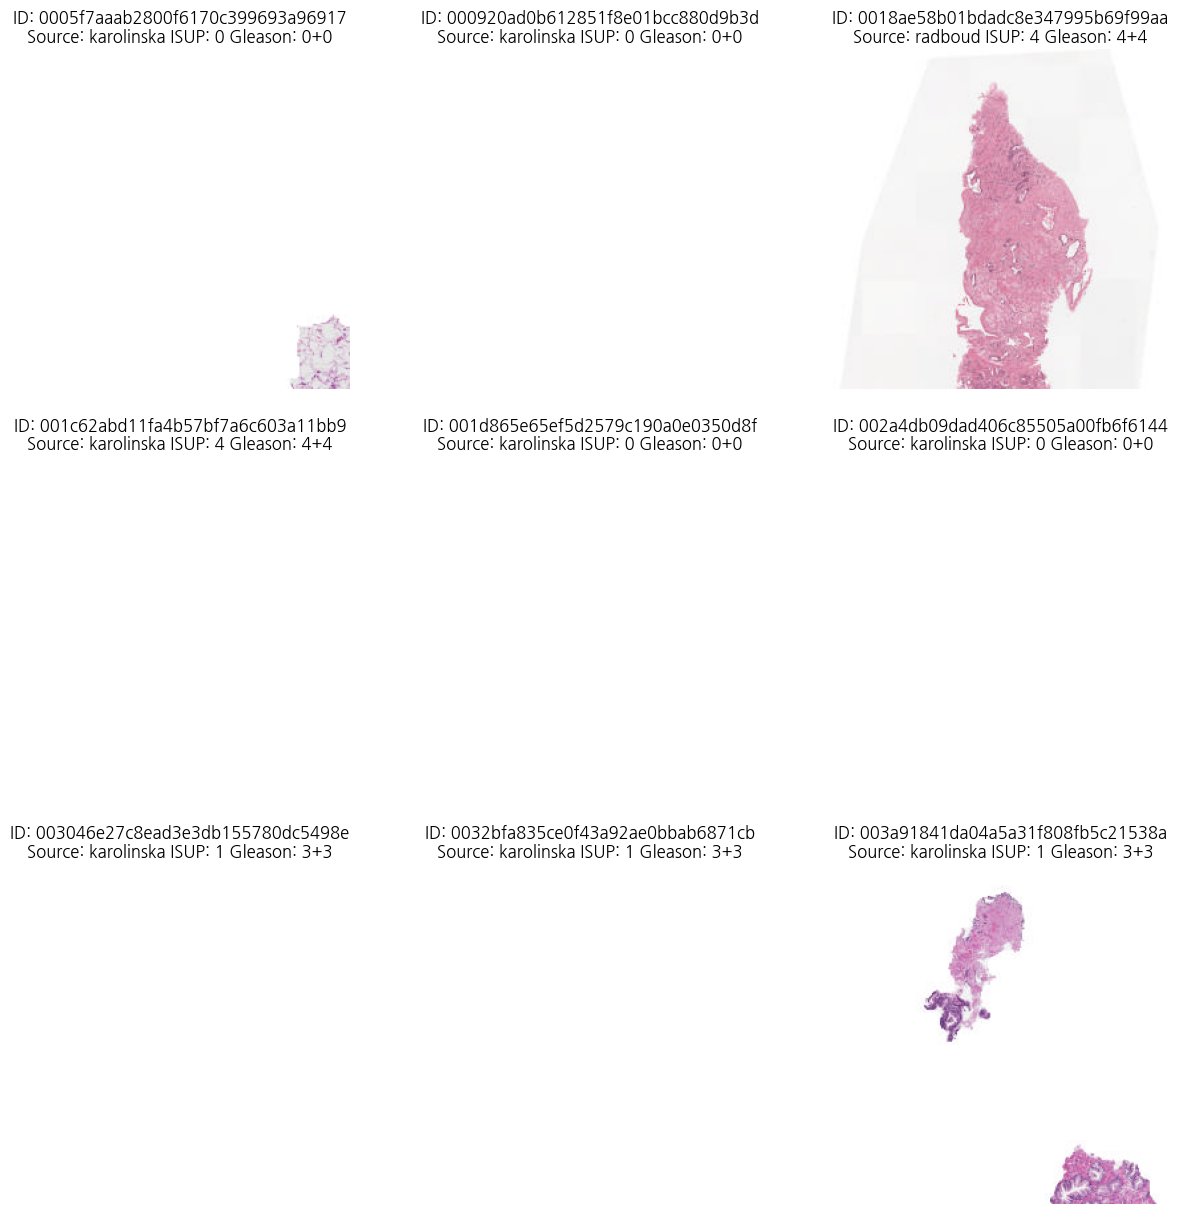

In [36]:
sample_df = train.head(9)
multi_plot(sample_df)

In [30]:
id_list = [
    '037504061b9fba71ef6e24c48c6df44d',
    '035b1edd3d1aeeffc77ce5d248a01a53',
    '059cbf902c5e42972587c8d17d49efed',
    '06a0cbd8fd6320ef1aa6f19342af2e68',
    '06eda4a6faca84e84a781fee2d5f47e1',
    '0a4b7a7499ed55c71033cefb0765e93d',
    '0838c82917cd9af681df249264d2769c',
    '046b35ae95374bfb48cdca8d7c83233f',
    '074c3e01525681a275a42282cd21cbde',]

slect_df = train[train['image_id'].isin(id_list)]

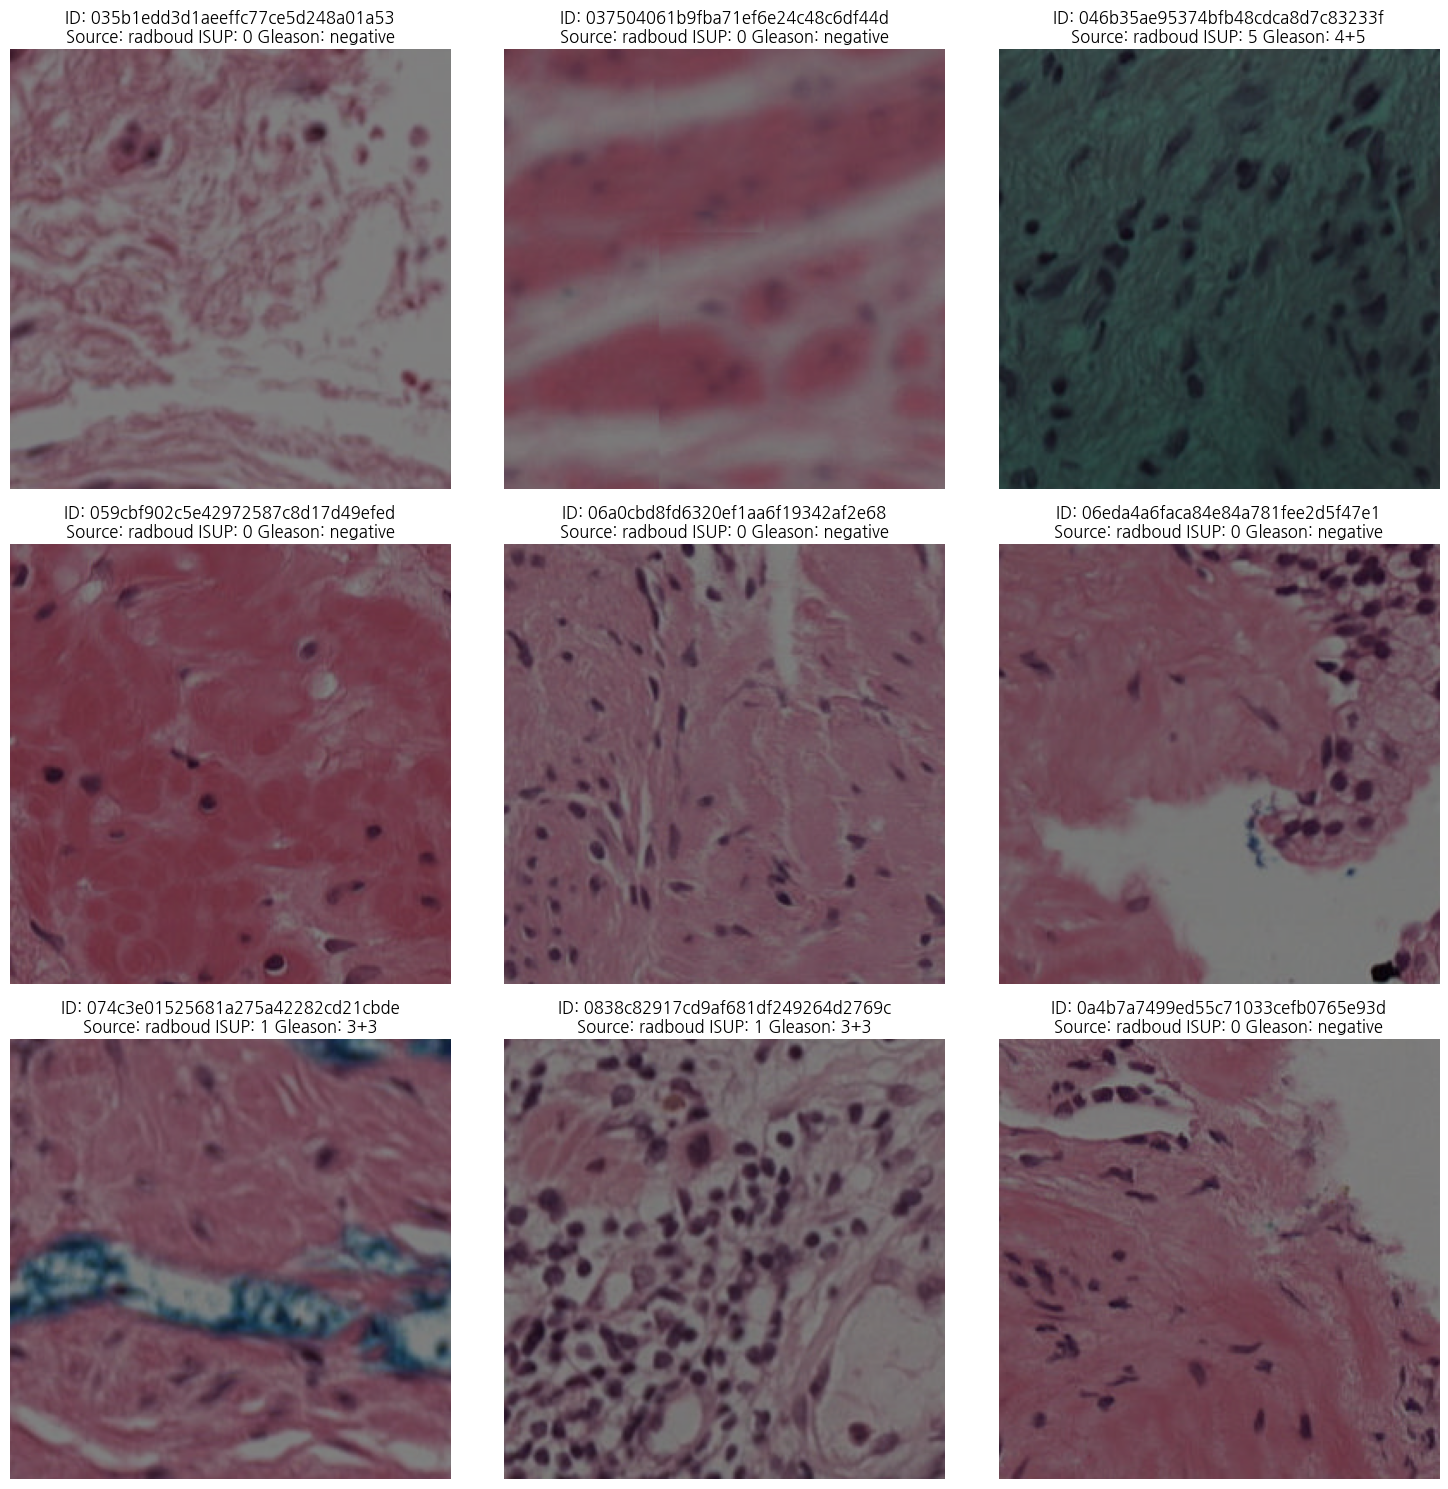

In [31]:
multi_plot(slect_df, (1780,1950), 0, (256,256))

In [32]:
import matplotlib
def mask_multi_plot(df, region=(0,0), level=-1, crop_size=(256,256)): 
    f, ax = plt.subplots(3,3, figsize=(15,15))
    for i, row in enumerate(df.itertuples()):
        image = openslide.OpenSlide(row.mask_path)
        slevel = image.level_count -1 if level == -1 else level
        patch = image.read_region(region, slevel, crop_size)
        cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
        ax[i//3, i%3].imshow(np.asarray(patch)[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5) 
        image.close()       
        ax[i//3, i%3].axis('off')
        
        image_id = row.image_id
        data_provider = row.data_provider
        isup_grade = row.isup_grade
        gleason_score = row.gleason_score
        ax[i//3, i%3].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score}")

    plt.show() 

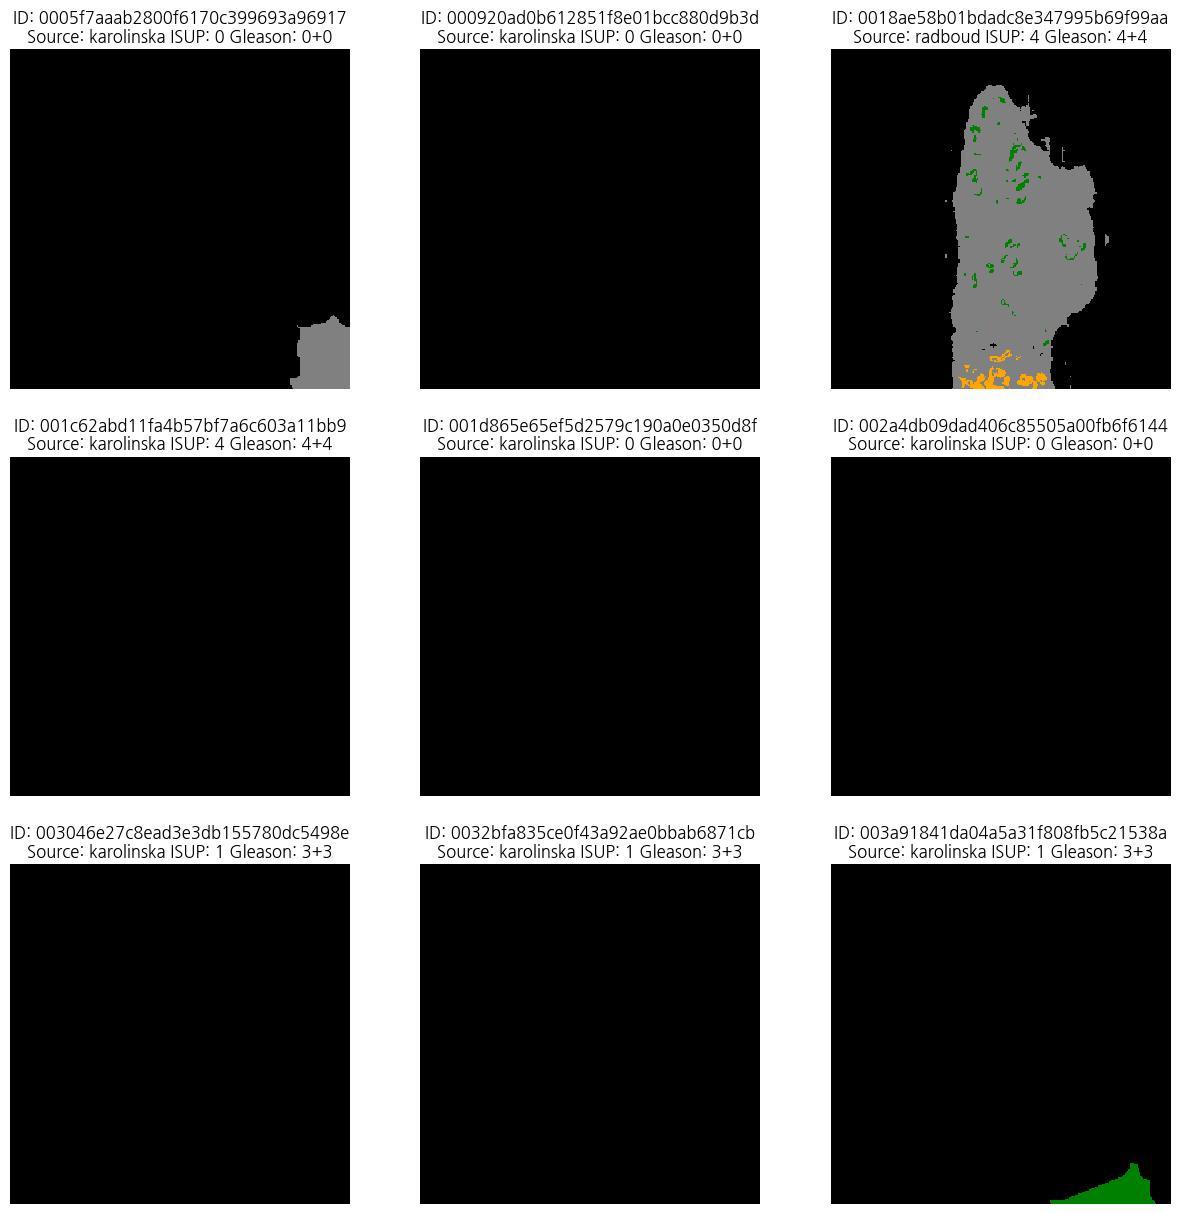

In [33]:
mask_multi_plot(sample_df)

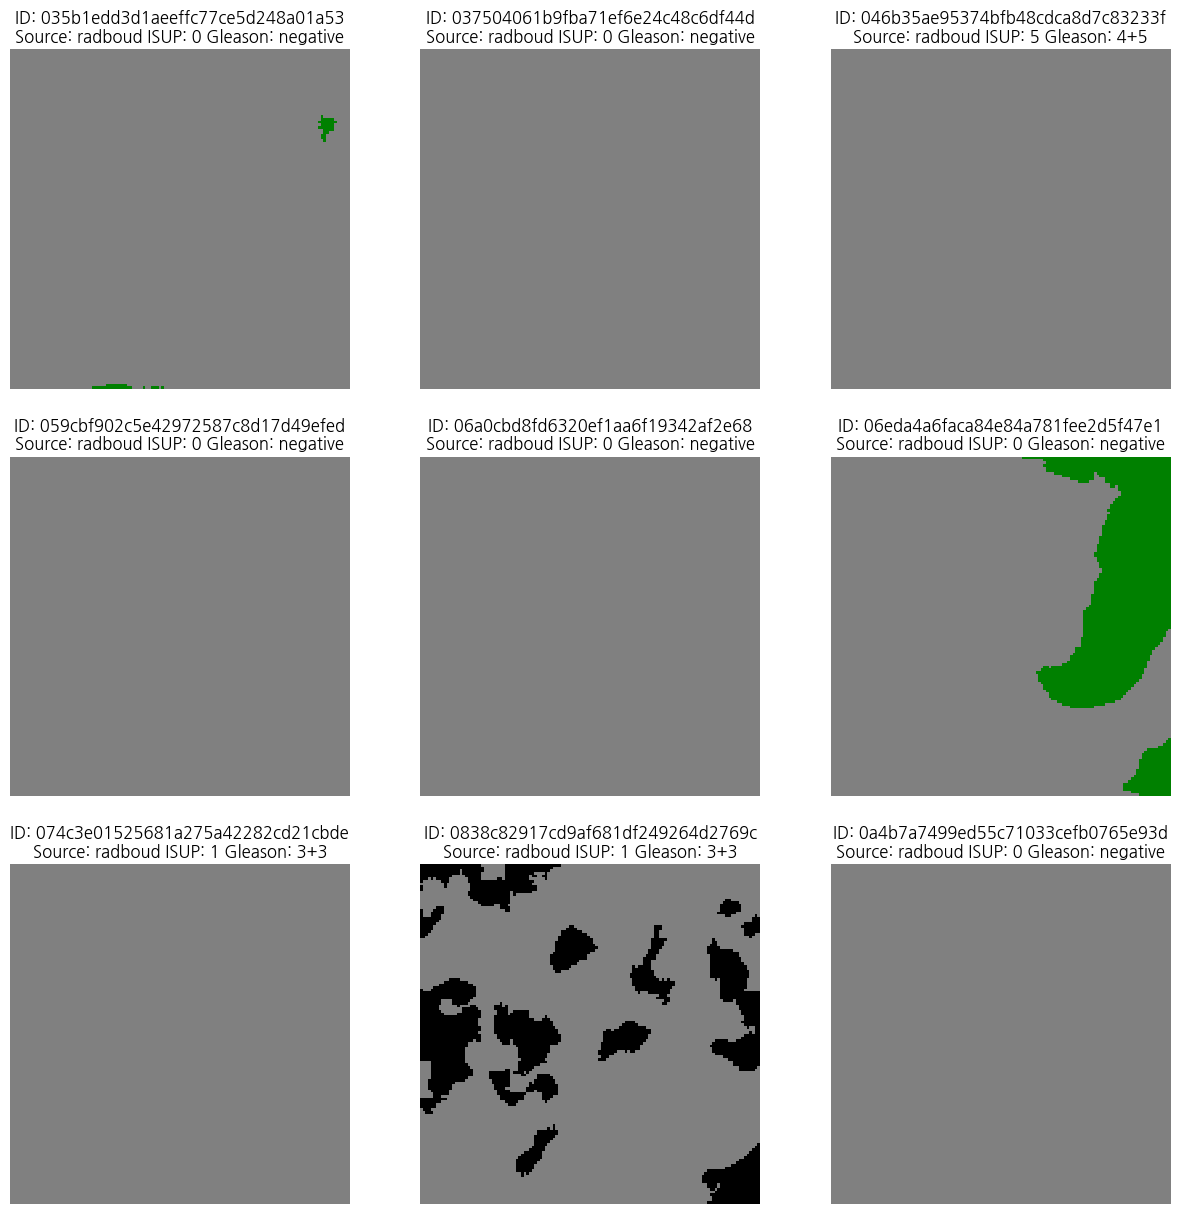

In [34]:
mask_multi_plot(slect_df, (1780,1950), 0, (256,256))

In [37]:
import PIL
#https://www.kaggle.com/code/spidyweb/prostate-cancer-panda-insight-eda## reference : 
def override_image(df, region=(0,0), level=-1, crop_size=(256,256), center='radboud', alpha=0.8, max_size=(800, 800)): 
    f, ax = plt.subplots(3,3, figsize=(15,15))
    for i, row in enumerate(df.itertuples()):
        
        slide = openslide.OpenSlide(row.img_path)
        mask = openslide.OpenSlide(row.mask_path)
        slevel = slide.level_count -1 if level == -1 else level
        slide_data = slide.read_region(region, slevel, crop_size)
        mask_data = mask.read_region(region, slevel, crop_size)
        mask_data = mask_data.split()[0]
        
        
        # Create alpha mask
        alpha_int = int(round(255*alpha))
        if center == 'radboud':
            alpha_content = np.less(mask_data.split()[0], 2).astype('uint8') * alpha_int + (255 - alpha_int)
        elif center == 'karolinska':
            alpha_content = np.less(mask_data.split()[0], 1).astype('uint8') * alpha_int + (255 - alpha_int)

        alpha_content = PIL.Image.fromarray(alpha_content)
        preview_palette = np.zeros(shape=768, dtype=int)

        if center == 'radboud':
            # Mapping: {0: background, 1: stroma, 2: benign epithelium, 3: Gleason 3, 4: Gleason 4, 5: Gleason 5}
            preview_palette[0:18] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 0, 1, 0, 1, 1, 0.7, 1, 0.5, 0, 1, 0, 0]) * 255).astype(int)
        elif center == 'karolinska':
            # Mapping: {0: background, 1: benign, 2: cancer}
            preview_palette[0:9] = (np.array([0, 0, 0, 0, 1, 0, 1, 0, 0]) * 255).astype(int)

        mask_data.putpalette(data=preview_palette.tolist())
        mask_rgb = mask_data.convert(mode='RGB')
        overlayed_image = PIL.Image.composite(image1=slide_data, image2=mask_rgb, mask=alpha_content)
        overlayed_image.thumbnail(size=max_size, resample=0)

        
        ax[i//3, i%3].imshow(overlayed_image) 
        slide.close()
        mask.close()       
        ax[i//3, i%3].axis('off')

        image_id = row.image_id
        data_provider = row.data_provider
        isup_grade = row.isup_grade
        gleason_score = row.gleason_score
        ax[i//3, i%3].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score}")


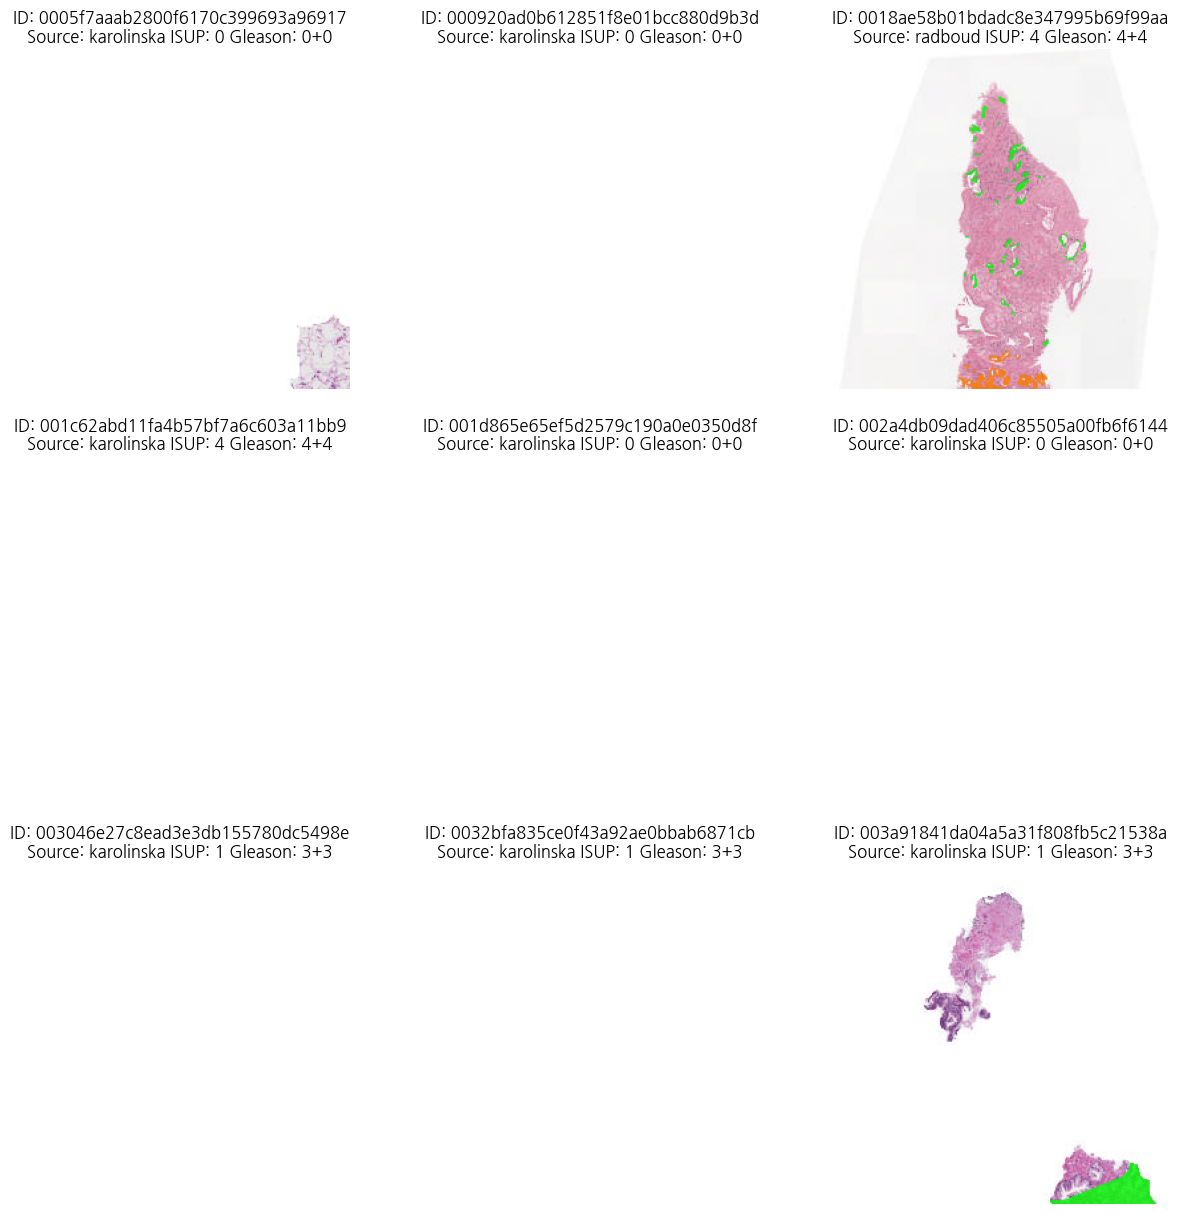

In [38]:
override_image(sample_df)

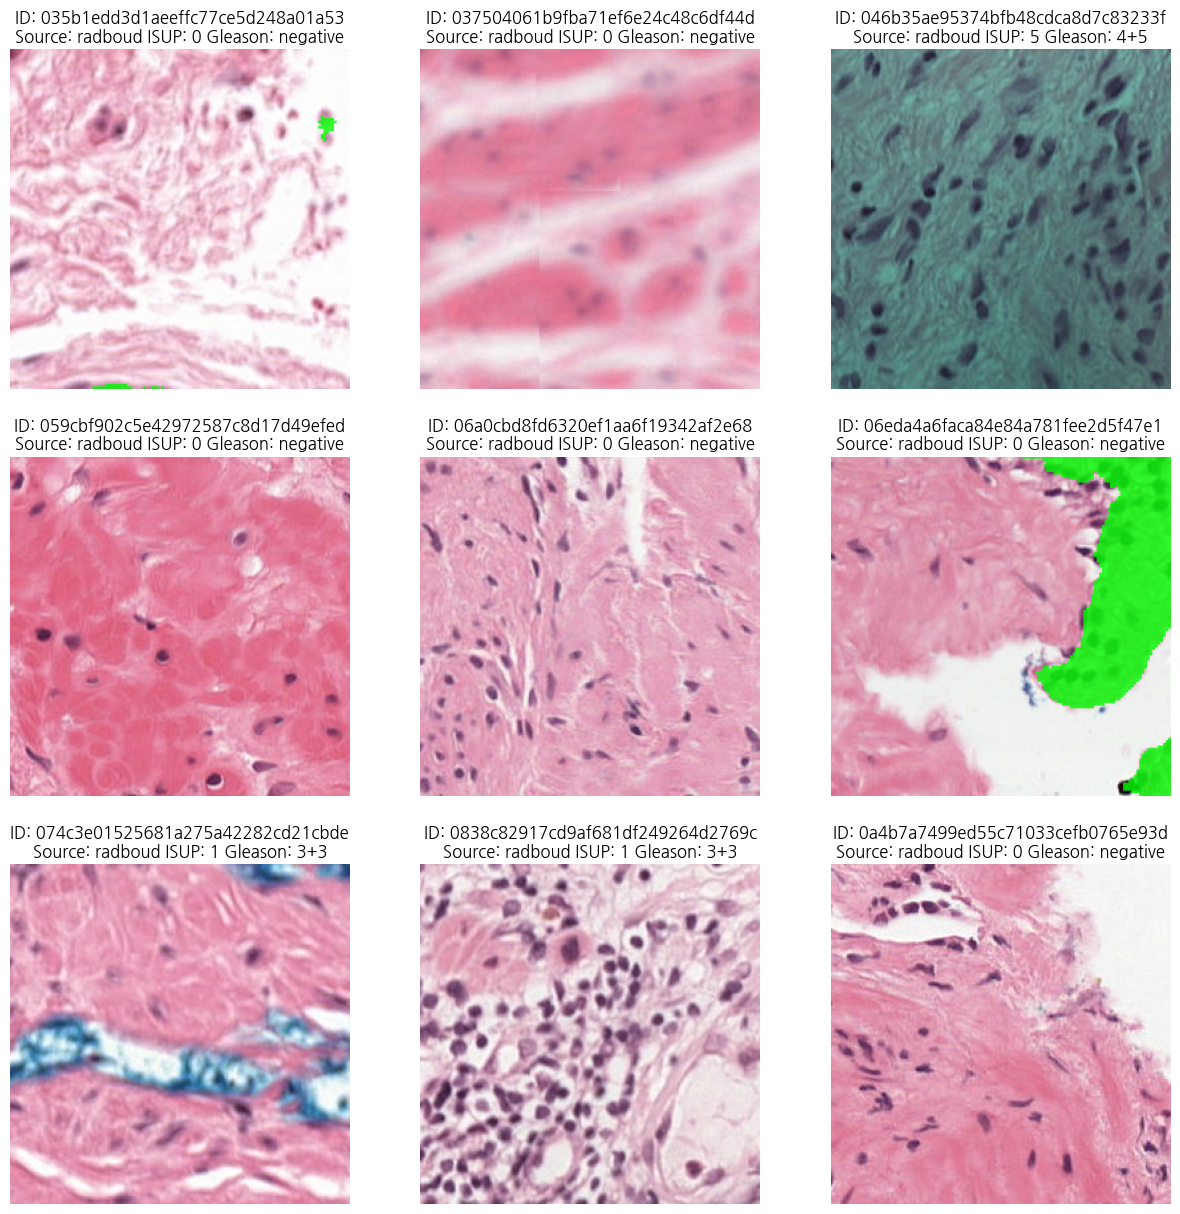

In [39]:
override_image(slect_df, (1780,1950), 0, (256,256))

In [40]:
def print_slide_details(slide, show_thumbnail=True, max_size=(600,400)):
    """Print some basic information about a slide"""
    # Generate a small image thumbnail
    if show_thumbnail:
        display(slide.get_thumbnail(size=max_size))

    # Here we compute the "pixel spacing": the physical size of a pixel in the image.
    # OpenSlide gives the resolution in centimeters so we convert this to microns.
    spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)
    
    print(f"File id: {slide}")
    print(f"Dimensions: {slide.dimensions}")
    print(f"Microns per pixel / pixel spacing: {spacing:.3f}")
    print(f"Number of levels in the image: {slide.level_count}")
    print(f"Downsample factor per level: {slide.level_downsamples}")
    print(f"Dimensions of levels: {slide.level_dimensions}")

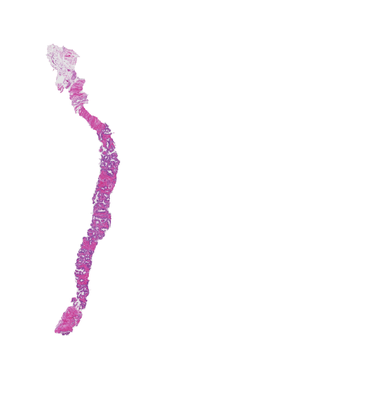

File id: OpenSlide(PosixPath('/home/minyoungxi/MINYOUNGXI/Medical/Medical Video Tutorial/train_images/0005f7aaab2800f6170c399693a96917.tiff'))
Dimensions: (27648, 29440)
Microns per pixel / pixel spacing: 0.452
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.0, 16.0)
Dimensions of levels: ((27648, 29440), (6912, 7360), (1728, 1840))


In [41]:
for row in sample_df.itertuples():
    biopsy = openslide.OpenSlide(row.img_path)
    print_slide_details(biopsy)
    biopsy.close()
    break

In [43]:
from tqdm import tqdm
import os
import openslide

meta_dict = {'width': [], 'height': [], 'spacing': [], 'level_count': []}

for row in tqdm(train.itertuples(), total=len(train)):
    # 파일 존재 여부 확인
    if not os.path.exists(row.img_path):
        continue

    slide = openslide.OpenSlide(row.img_path)
    
    spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)
    
    meta_dict['width'].append(slide.dimensions[0])
    meta_dict['height'].append(slide.dimensions[1])
    meta_dict['spacing'].append(spacing)
    meta_dict['level_count'].append(slide.level_count)


 87%|████████▋ | 9219/10616 [00:04<00:00, 1978.20it/s]


OpenSlideUnsupportedFormatError: Unsupported or missing image file